In [1]:
# # Install PyWake if needed
# try:
#     import py_wake
# except ModuleNotFoundError:
#     !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

## Instalação
**(topfarm é recomendado para <3.12)**

- conda create --name ENVNAME python=3.11 
- conda activate ENVNAME
- pip install py_wake
- pip install topfarm
- pip install pyproj

In [2]:
import xarray as xr #Similar ao pandas mas com melhor eficiencia para trabalhar com matrizes multidimensionais, muito bom para dados georref
import numpy as np
from scipy.stats import weibull_min
from py_wake.site.xrsite import XRSite
from py_wake.site.shear import PowerShear
import matplotlib.pyplot as plt
from py_wake.flow_map import XYGrid, YZGrid, XZGrid
from pyproj import Proj, Transformer
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import pandas as pd
from topfarm.utils import regular_generic_layout, regular_generic_layout_gradients



## Criação dos Dados para entrada no modelo ##

## Exemplo de padrão de informações para criação de um site com baseado em weibull ##
# Caracteristicas do vento #
f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]#np.linspace(0, 360, len(f), endpoint=False)
ti = [2.72, 1.95, 1.98, 2.09, 2.10, 2.05, 2.01, 2.00, 1.95, 1.90, 1.85, 1.80]


In [3]:
f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]#np.linspace(0, 360, len(f), endpoint=False)
ti = [2.72, 1.95, 1.98, 2.09, 2.10, 2.05, 2.01, 2.00, 1.95, 1.90, 1.85, 1.80]


In [4]:
Weibull_A = np.array(A)
Weibull_k = np.array(k)
#Configura o  Turbulence intensity - TI, e 
#ti = 0.1 # Desvio padrão da velocidade do vento / Velocidade média do vento
#Gera o vetor de direção "referencia"
wd = np.linspace(0, 360, len(f), endpoint=False)

ds = xr.Dataset(
    data_vars={
        'Sector_frequency': ('wd', f),
        'Weibull_A': ('wd', Weibull_A),
        'Weibull_k': ('wd', Weibull_k),
        'TI': ('wd', ti)   #colocar uma lista
    },
    coords={
        'wd': wd,
    }
)

In [5]:
ds

<xarray.Dataset> Size: 480B
Dimensions:           (wd: 12)
Coordinates:
  * wd                (wd) float64 96B 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
Data variables:
    Sector_frequency  (wd) float64 96B 0.036 0.039 0.052 ... 0.147 0.1 0.052
    Weibull_A         (wd) float64 96B 9.177 9.782 9.532 ... 11.69 11.64 10.09
    Weibull_k         (wd) float64 96B 2.393 2.447 2.412 ... 2.607 2.627 2.326
    TI                (wd) float64 96B 2.72 1.95 1.98 2.09 ... 1.95 1.9 1.85 1.8

UniformWeibullSite: Site with uniform sector-dependent Weibull distributed wind speed.

WaspGridSite: Site with gridded non-uniform inflow based on *.grd files exported from WAsP.

XRSite: The flexible general base class behind all Sites.

In [6]:
# Create an XRSite object: cria o dataset para altura de referencia da maquina utilizando lei de potencia
site = XRSite(ds=ds, shear=PowerShear(h_ref=100)) # necessário é possível alpha=.1, interp_method='nearest' que vem assim por default
# Possibilidade de criar com outro modelo de shear, por exemplo:
#site = XRSite(ds= ds, shear=LogShear(h_ref=100, z0=.15))


Se precisar salvar varios arquivos NetCDF para salvar as distribuições de Weibull para usar depois e calcular o parque de forma separada

- Salvar o site em um netCDF
site_ds = site.ds
site_ds.to_netcdf('teste_site.nc')

- Carregar o XRSite data do NetCDF
loaded_site_ds = xr.open_dataset('teste_site.nc')

- Create a new XRSite object using the loaded data
loaded_site = XRSite(ds=loaded_site_ds, shear=PowerShear(h_ref=100))

- Verify the loaded data (optional)
print(loaded_site.ds)

In [7]:
# Replace 'your_file.csv' with the path to your CSV file
csv_file_path = '/media/wendell/Windows Backup/Arquivos_wendell/NREL_5MW_126_RWT.csv'

# Read the CSV file into a DataFrame
tb = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(tb.head())

FileNotFoundError: [Errno 2] No such file or directory: '/media/wendell/Windows Backup/Arquivos_wendell/NREL_5MW_126_RWT.csv'

In [8]:
############################################################################################
#************Turbina NREL Exemplo de criação um objeto turbina
############################################################################################
vel_turbine = tb['Wind Speed [m/s]']
pot_turbine = tb['Power [kW]']
ct = tb['Ct [-]']

# Define the hub height of the turbine
hub_height = 110  # in meters
diameter_turb = 126  # in meters

wt_NREL = WindTurbine(name='NRel5MW',
                    diameter=diameter_turb,
                    hub_height=hub_height,
                    powerCtFunction=PowerCtTabular(vel_turbine,pot_turbine,'kW',ct))

NameError: name 'tb' is not defined

In [ ]:
#Importes para conseguir gerar o Wake model
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models.gaussian import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum

In [ ]:
# x, y, hemisferio = convert_to_utm_vectorized(x, y)
# print(x, y, hemisferio)
n_wt = 3

rotor_diameter = 150
y_dist = 12*rotor_diameter # Criação do padrão de espaçamento dos aerogeradores
x_dist = 3*rotor_diameter
angulo = 30 #Angulo da disposição da grade
stagger = 1 * rotor_diameter   # Desalinhar os aerogeradores para criar a grade baseado no diametro

def reg_func(n_wt, sx, sy, stagger, rotation, **kwargs): # Função para gerar uma grade regular e generica de disposição dos aeros
    x, y = regular_generic_layout(n_wt, sx, sy, stagger, rotation)
    return [x, y]

x, y = reg_func(n_wt, x_dist, y_dist, stagger, angulo)

In [ ]:
from py_wake.wind_farm_models import All2AllIterative
from py_wake.turbulence_models import CrespoHernandez, STF2017TurbulenceModel
from py_wake.superposition_models import LinearSum, CumulativeWakeSum, WeightedSum
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models import FugaDeficit, SelfSimilarityDeficit, SelfSimilarityDeficit2020 # blockage deficit


In [ ]:
# Configuração do xarray para não expandir os dados por padrão
xr.set_options(display_expand_data=False)


#wf_model = Bastankhah_PorteAgel_2014(site, my_wt, k=0.0324555)

# wf_model = PropagateDownwind(site, wt_NREL,
#                              wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
#                              superpositionModel=LinearSum())

# wf_model = All2AllIterative(site, wt_NREL,
#                              wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=False),
#                              superpositionModel=LinearSum(), blockage_deficitModel=SelfSimilarityDeficit2020(),
#                              turbulenceModel=STF2017TurbulenceModel())


wf_model = All2AllIterative(site, wt_NREL,
                             wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                             superpositionModel=LinearSum(), blockage_deficitModel=SelfSimilarityDeficit2020(),
                             turbulenceModel=STF2017TurbulenceModel())

#x = [-500., -500., -500.,    0.,    0.,    0.,  500.,  500.,  500.]
#y = [-500.,    0.,  500., -500.,    0.,  500., -500.,    0.,  500.]

#x, y =convert_to_utm_vectorized(np.array([-5.756739]), np.array([-36.007004]))
sim_res = wf_model(x, y,     # arrays com as posições dos aerogeradores
                   h=None,   # wind turbine heights (defaults to the heights defined in windTurbines)
                   wd=None,  # Wind direction, default is all direction, list or value should be passed as argument
                   ws=None,  # Wind speed, default is all speeds, list or values should be passed
                   n_cpu=None,  # Number of CPUs to use, default is all available CPUs
                  )

In [ ]:
#x,y = convert_to_utm_vectorized(np.array([-7.414711, -7.387802]), np.array([-38.917034, -38.889893]))
wf_model


In [ ]:
sim_res

<xarray.SimulationResult> Size: 2MB
Dimensions:           (wt: 3, wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * wt                (wt) int64 24B 0 1 2
    type              (wt) float64 24B 0.0 0.0 0.0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 199kB 3.086 4.081 ... 24.23 25.24
    TI_eff            (wt, wd, ws) float64 199kB 2.72 2.72 2.72 ... 2.689 2.689
    Power             (wt, wd, ws) float64 199kB 5.236e+04 1.959e+05 ... 5e+06
    CT                (wt, wd, ws) float64 199kB 2.435 1.738 ... 0.08374 0.07737
    h                 (wt, wd, ws) float64 199kB 110.0 110.0 ... 110.0 110.0
    x                 (wt, wd, ws) float64 199kB 0.0 0.0 0.0 ... -900.0 -900.0
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.5
    ws_u              (ws) float64 184B 3.5 4.5 5.5 6.5 ... 22.5 23.5 24.5 25.5
    Weibull_A         (wd) float64 3kB 9.177 9.197 9.217 ... 9.268 9.238 9.207
    Weibull_k         (wd) float64 3kB 2.393 2.395 2.397 ... 2.386 2.389 2.391
    Sector_frequency  (wd) float64 3kB 0.0012 0.001203 ... 0.001236 0.001218
    P                 (wd, ws) float64 66kB 6.15e-05 8.565e-05 ... 2.45e-08

In [ ]:
#Produção de energia eletrica para a turbina zero (wt=0) com o vento na direção
print(sim_res.Power.sel(wt=0))

#Potencia total da turbina 0
total_power = sim_res.Power.sel(wt=2).sum().values/1e6
print(total_power)

#AEP das turbinas de todas as velocidade e direções, aep por padrão considera efeitos de perda"sim_res.aep(with_wake_loss=False).sum().data"
print('Total power: %f GWh'%sim_res.aep().sum().values)


<xarray.DataArray 'Power' (wd: 360, ws: 23)> Size: 66kB
5.236e+04 1.959e+05 4.293e+05 7.742e+05 1.24e+06 ... 5e+06 5e+06 5e+06 5e+06
Coordinates:
  * ws       (ws) int64 184B 3 4 5 6 7 8 9 10 11 ... 17 18 19 20 21 22 23 24 25
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    wt       int64 8B 0
    type     float64 8B 0.0
Attributes:
    Description:  Power [W]
30633.771626060538
Total power: 71.330696 GWh


In [ ]:
total_power = sim_res.Power.sel(wt=2, wd=100).sum().values/1e6
print('Total power: %f MW'%total_power)

Total power: 85.324784 MW


In [ ]:
sim_res

<xarray.SimulationResult> Size: 2MB
Dimensions:           (wt: 3, wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * wt                (wt) int64 24B 0 1 2
    type              (wt) float64 24B 0.0 0.0 0.0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 199kB 3.086 4.081 ... 24.23 25.24
    TI_eff            (wt, wd, ws) float64 199kB 2.72 2.72 2.72 ... 2.689 2.689
    Power             (wt, wd, ws) float64 199kB 5.236e+04 1.959e+05 ... 5e+06
    CT                (wt, wd, ws) float64 199kB 2.435 1.738 ... 0.08374 0.07737
    h                 (wt, wd, ws) float64 199kB 110.0 110.0 ... 110.0 110.0
    x                 (wt, wd, ws) float64 199kB 0.0 0.0 0.0 ... -900.0 -900.0
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.5
    ws_u              (ws) float64 184B 3.5 4.5 5.5 6.5 ... 22.5 23.5 24.5 25.5
    Weibull_A         (wd) float64 3kB 9.177 9.197 9.217 ... 9.268 9.238 9.207
    Weibull_k         (wd) float64 3kB 2.393 2.395 2.397 ... 2.386 2.389 2.391
    Sector_frequency  (wd) float64 3kB 0.0012 0.001203 ... 0.001236 0.001218
    P                 (wd, ws) float64 66kB 6.15e-05 8.565e-05 ... 2.45e-08

In [ ]:
# Define grid limits based on your region of interest
x_min, x_max = x.min() - 500, x.max() + 500
y_min, y_max = y.min() - 500, y.max() + 500
res_grid = 100  # Define the resolution of the grid
grid = XYGrid(x=np.linspace(x_min, x_max, res_grid), y=np.linspace(y_min, y_max, res_grid))
print(grid)

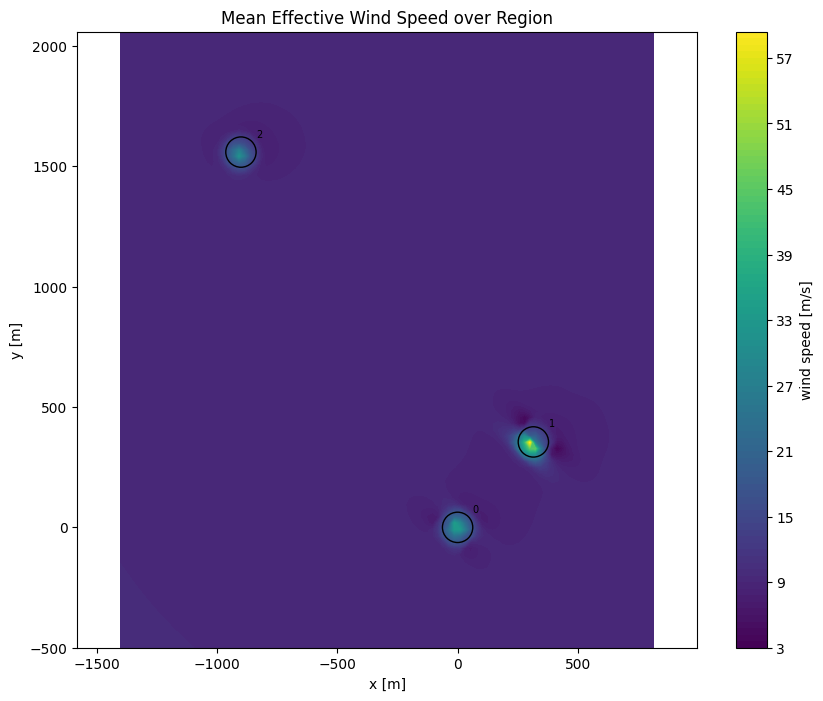

In [ ]:
flow = sim_res.flow_map(grid=grid)
plt.figure(figsize=(10, 8))
flow.plot_wake_map(cmap='viridis')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Mean Effective Wind Speed over Region')
plt.show()

In [ ]:
flow

<xarray.FlowMap> Size: 4GB
Dimensions:  (x: 100, y: 100, h: 1, wd: 360, ws: 23)
Coordinates:
  * x        (x) float64 800B -1.4e+03 -1.378e+03 -1.355e+03 ... 792.3 814.7
  * y        (y) float64 800B -500.0 -474.2 -448.3 ... 2.033e+03 2.059e+03
  * h        (h) float64 8B 110.0
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * ws       (ws) int64 184B 3 4 5 6 7 8 9 10 11 ... 17 18 19 20 21 22 23 24 25
Data variables:
    WS_eff   (y, x, h, wd, ws) float64 662MB 3.035 4.043 5.051 ... 24.23 25.24
    TI_eff   (y, x, h, wd, ws) float64 662MB 2.72 2.72 2.72 ... 2.689 2.689
    WD       (y, x, h, wd, ws) int64 662MB 0 0 0 0 0 0 ... 359 359 359 359 359
    WS       (y, x, h, wd, ws) float64 662MB 3.029 4.038 5.048 ... 24.23 25.24
    TI       (y, x, h, wd, ws) float64 662MB 2.72 2.72 2.72 ... 2.689 2.689
    P        (y, x, h, wd, ws) float64 662MB 6.15e-05 8.565e-05 ... 2.45e-08

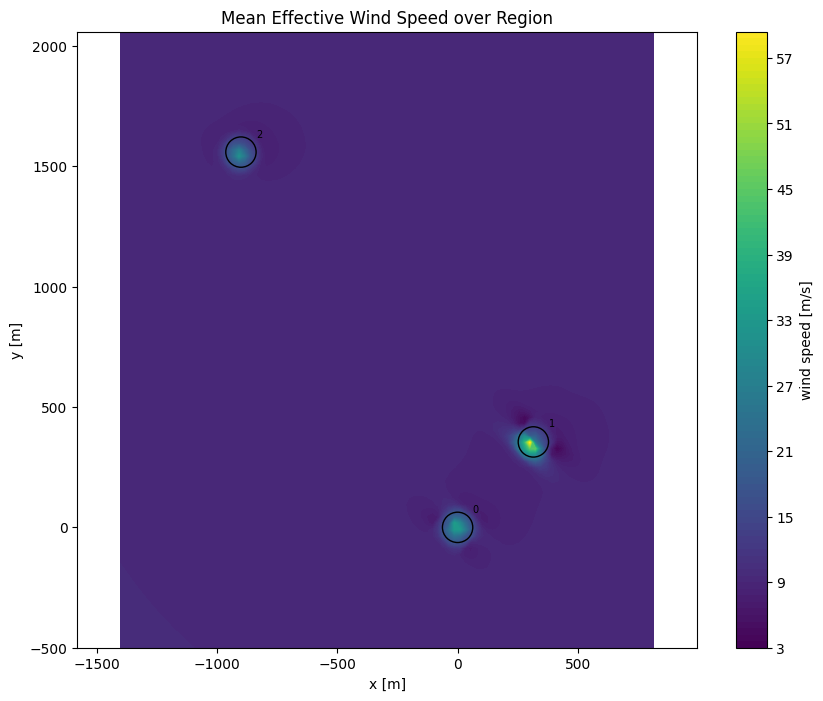

In [ ]:
# Define grid limits based on your region of interest
x_min, x_max = x.min() - 500, x.max() + 500
y_min, y_max = y.min() - 500, y.max() + 500

# Create a grid for the region
grid = XYGrid(x=np.linspace(x_min, x_max, 100), y=np.linspace(y_min, y_max, 100))

# Calculate the flow map for mean wind direction and speed (or average over all)
flow_map = sim_res.flow_map(grid=grid)

plt.figure(figsize=(10, 8))
flow_map.plot_wake_map(cmap='viridis')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Mean Effective Wind Speed over Region')
plt.show()

In [ ]:
sim_res.groupby_bins

<bound method Dataset.groupby_bins of <xarray.SimulationResult> Size: 2MB
Dimensions:           (wt: 3, wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * wt                (wt) int64 24B 0 1 2
    type              (wt) float64 24B 0.0 0.0 0.0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 199kB 3.086 4.081 ... 24.23 25.24
    TI_eff            (wt, wd, ws) float64 199kB 2.72 2.72 2.72 ... 2.689 2.689
    Power             (wt, wd, ws) float64 199kB 5.236e+04 1.959e+05 ... 5e+06
    CT                (wt, wd, ws) float64 199kB 2.435 1.738 ... 0.08374 0.07737
    h                 (wt, wd, ws) float64 199kB 110.0 110.0 ... 110.0 110.0
    x                 (wt, wd, ws) float64 199kB 0.0 0.0 0.0 ... -900.0 -900.0
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.5
    ws_u 

Text(0.5, 1.0, 'Wake map for 150 deg and 10 m/s')

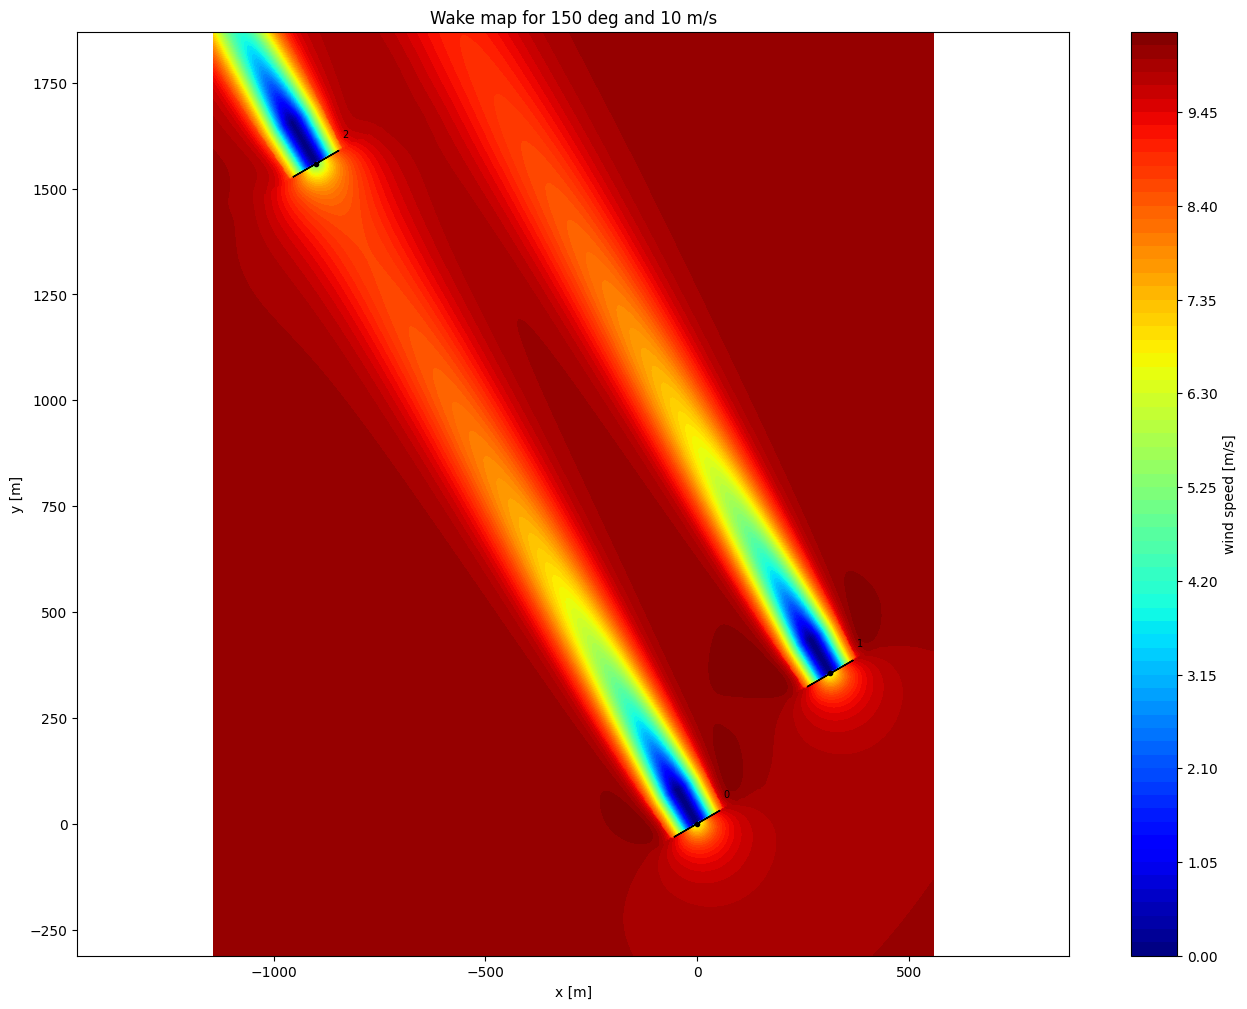

In [ ]:

plt.figure(figsize=(16, 12))
teste = wf_model(x, y, type=0, wd=150, ws=10, h=110, n_cpu=None).flow_map().plot_wake_map(cmap='jet')
# flow_map.plot_wake_map(levels=10, # contourf levels (int or list of levels)
#                        cmap='jet', # color map
#                        plot_colorbar=False,
#                        plot_windturbines=False,
#                        ax=None)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for'+ f' {150} deg and {10} m/s')


In [ ]:
# sim_res.flow_map().to_netcdf("/home/wendell/work/output_teste_pywake.nc")

In [ ]:
# plt.figure(figsize=(12,4))
# sim_res.flow_map(YZGrid(x=-500, y=None, resolution=1000), wd=150, ws=None).plot_wake_map(cmap='jet')
# plt.xlabel('y [m]')
# plt.ylabel('z [m]')

In [ ]:
# plt.figure(figsize=(12,4))
# sim_res.flow_map(grid=XZGrid(y=0, resolution=1000), wd=90, ws=None).plot_wake_map(cmap='jet')
# plt.xlabel('x [m]')
# plt.ylabel('z [m]')

In [ ]:
# #Import para simulação da farm com o wake model
# # Import topfarm problem, plotting support, constraint classes and generic cost model component
# from topfarm import TopFarmProblem
# from topfarm.plotting import NoPlot, XYPlotComp
# from topfarm.constraint_components.boundary import XYBoundaryConstraint, CircleBoundaryConstraint
# from topfarm.constraint_components.spacing import SpacingConstraint
# from topfarm.cost_models.cost_model_wrappers import CostModelComponent
# from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent   #cost model
# from topfarm.easy_drivers import EasyScipyOptimizeDriver, EasySimpleGADriver
# from topfarm.examples.iea37 import get_iea37_initial, get_iea37_constraints, get_iea37_cost

In [ ]:
# x

In [ ]:
# n_wt = 3
# n_wd = 12


# cost_comp = PyWakeAEPCostModelComponent(wf_model, n_wt, wd=wd)

# #Gera as direções para simular o posicionamento
# wd = np.linspace(0.,360.,n_wd, endpoint=False)

# initial_position = {'x': x, 'y': y}

# driver = EasyScipyOptimizeDriver(maxiter=300, tol=1e-12) # o metodo utilizado para otimizar
# #driver  = EasySimpleGADriver(max_gen=300, pop_size=25, run_parallel=True)

In [ ]:
# print(x, y)
# print(initial_position)

In [ ]:
# # set up a "boundary" array with arbitrary points for use in the example
# boundary = np.array([(-1500, -1500), (-1500, 1500), (1500, -1500), (1500, 1500)])
# boundary = np.array([(-1900, 2500), (-4500, 4550), (-1000, -2500), (1500, 5000)])


# contraints_teste = XYBoundaryConstraint(boundary, 'convex_hull') #Metodo para criação do formato do boundary
# limites = [SpacingConstraint(300), contraints_teste]


In [ ]:
# #Criando os parametros para a otimização com o TopFarm
# tf_problem = TopFarmProblem(
#             initial_position,
#             cost_comp = cost_comp,
#             constraints=limites,
#             driver=driver,
#             plot_comp=XYPlotComp())

# _, state, _ = tf_problem.optimize()

# #print(state) # Posições otimizadas

In [ ]:
# #Simulação para o plot
# wf_model(state['x'], state['y'], type=0, wd=[150], ws=10, h=100, n_cpu=None).flow_map().plot_wake_map()
# plt.xlabel('x [m]')
# plt.ylabel('y [m]')
# plt.title('Wake map for'+ f' {150} deg and {10} m/s')

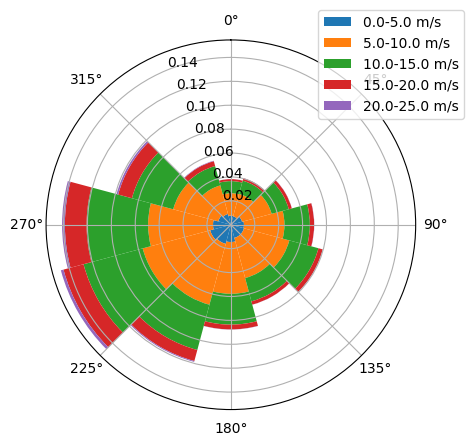

In [ ]:
_ = site.plot_wd_distribution(n_wd=12, ws_bins=[0,5,10,15,20,25]) #PLota a rosa dos ventos com a velocidade

In [ ]:
# #Import para usar duas funções para otimizar x,y e levar yaw
# import warnings
# warnings.filterwarnings("ignore")

# from topfarm.cost_models.cost_model_wrappers import CostModelComponent
# from topfarm import TopFarmProblem
# from topfarm.plotting import NoPlot
# from topfarm.easy_drivers import EasyScipyOptimizeDriver


In [ ]:

# #choosing the flow cases for the optimization
# wsp = np.arange(3, 13, 1)
# wdir = np.arange(100, 170, 10)

# #getting initial position of turbines
# n_wt = len(x)

# #setting up yaw angles for each turbine, wind direction and wind speed
# i = n_wt
# k = wsp.size
# l = wdir.size
# yaw_zero = np.zeros((i,l,k))  #initial condition of yaw angles


In [ ]:
# #criação da função de custo, levando em consideração x,y e yaw dos aerogeradores
# def aep_func(x, y, yaw_ilk):
#     simres = wf_model(x,y,wd=wdir,ws=wsp,yaw=yaw_ilk, tilt=0)
#     aep = simres.aep().sum()
#     return aep


In [ ]:
# #criação do modelo de custo
# cost_comp = CostModelComponent(input_keys=['x','y',('yaw_ilk', np.zeros((i, l, k)))],
#                                           n_wt = n_wt,
#                                           cost_function = aep_func,
#                                           objective=True,
#                                           maximize=True,
#                                           output_keys=[('AEP', 0)]
#                                           )


In [ ]:
# #limitador da otimização
# maxiter=300
# tol=1e-8
# ec=1e-4

# problem = TopFarmProblem(design_vars={'x': x, 'y': y, 'yaw_ilk': (yaw_zero, -30, 30)},  #setting up initial values and lower and upper bounds for yaw angles
#                           n_wt=n_wt,
#                           cost_comp=cost_comp,
#                           driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter, tol=tol),
#                           plot_comp=NoPlot(),
#                           constraints=limites,
#                           expected_cost=ec)

# _, state,_ = problem.optimize()


In [ ]:
# #PLot levando em consideração a posição e o Yaw dependendo de vento e velocidade
# simulationResult = wf_model(state['x'],state['y'],wd=wdir, ws=wsp, yaw=state['yaw_ilk'][:,:,0], tilt=0)
# plt.figure(figsize=(12,6))
# simulationResult.flow_map().plot_wake_map()
# plt.xlabel('x [m]')
# plt.ylabel('y [m]')

# print(simulationResult.aep().sum().values)
# state['yaw_ilk'].shape



In [ ]:
# state['yaw_ilk']

In [ ]:
# simulationResult.flow_map()

In [ ]:
# simulationResult.flow_map().to_netcdf("/home/wendell/work/output_teste_pywake.nc")

In [ ]:
# simulationResult.aep_map()

## AEP(Produção anual de energia):
- AEP é a quantidade total acumulada de energia que uma única turbina ou um parque eólico inteiro gerou ao longo de um ano completo.

## Exemplo: Calculo de AEP
O Exemplo abaixo mostra como fazer o calculo de AEP

In [ ]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80, wt_x, wt_y, wt16_x, wt16_y
from py_wake import NOJ

#here we import the turbine, site and wake deficit model to use.
windTurbines = V80()
site = Hornsrev1Site()
noj = NOJ(site,windTurbines)

In [ ]:
simulationResult = noj(wt16_x,wt16_y)

In [ ]:
simulationResult.aep()

## Exemplo 2: Selecionando uma turbina
- O Exemplo abaixo estamos fazendo o mesmo calculo de AEP feito acima, mas selecionando só uma turbina eolica

In [ ]:
simulationResult.sel(wt=2)

In [ ]:
print(f"Total AEP: {float(simulationResult.Power.sel(wt=2).sum().values)/1e9:.2f} GWh")

## PLOTANDO GRÁFICO DE AEP (UTILIZANDO WT, WD E WS)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plotando o AEP de cada turbina
plt.figure()
aep = simulationResult.aep()
windTurbines.plot(wt16_x, wt16_y)
c =plt.scatter(wt16_x, wt16_y, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.title('AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')
plt.xticks(rotation=45)

#Gráfico AEP vs Velocidade do Vento
plt.figure()
aep.sum(['wt','wd']).plot()
plt.xlabel("Wind speed [m/s]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind speed')
plt.xticks(rotation=45)

#Gráfico AEP vs Direção do Vento
plt.figure()
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction')
plt.xticks(rotation=45)

#Gráfico wind farm, para visualizar o comportamento de cada turbina
wind_speed = 10
wind_direction = 270

plt.figure()
flow_map = simulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(18,10))
flow_map.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for' + f' {wind_speed} m/s and {wind_direction} deg')

- O gráfico 1, está mostrando a produção anual de energia de cada turbina e sua posição no site.
- O gráfico 2, mostra o quanto de energia está sendo produzido em determinada velocidade do vento.
- O gráfico 3, sinaliza à direção do vento com maior produção de energia.
- O gráfico 4, faz uma simulação de esfeito esteira no nosso parque e como influência na velocidade de cada turbina.